In [1]:
import os
import torch
import torchvision
from torchvision.io import read_image
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

In [2]:
# MANUAL_SEED = 42
BATCH_SIZE = 32
SHUFFLE = True

In [3]:
class LandscapeDataset(Dataset):
    def __init__(self, transform=None):
        self.dataroot = '/kaggle/input/cartoondata/Training Data'
        self.images = [img for img in os.listdir(f'{self.dataroot}/color') if img != '.DS_Store']
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Get image Paths
        img_path = self.images[idx]

        # Load the images
        color_img = read_image(f'{self.dataroot}/color/{img_path}') / 255
        gray_img = read_image(f'{self.dataroot}/gray/{img_path}') / 255

        if self.transform:
            color_img = self.transform(color_img)
            gray_img = self.transform(gray_img)

        return color_img, gray_img


In [4]:
transform = transforms.Compose([
    transforms.Resize((150, 150), antialias=False),
])
# Load the dataset
dataset = LandscapeDataset(transform=transform)

# Split the data into train and test data
train_set, test_set = random_split(dataset, [0.8, 0.2], generator=torch.Generator())

# Load the train and set data
trainloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
testloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

In [5]:

# Visualize some images
def show_images(color, gray):
    fig, axs = plt.subplots(5, 2, figsize=(15, 15))
    axs[0, 0].set_title('Grayscale')
    axs[0, 1].set_title('Color')
    for i in range(5):
        axs[i, 0].imshow(gray[i].permute(1,2,0), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(color[i].permute(1,2,0))
        axs[i, 1].axis('off')
    plt.show()

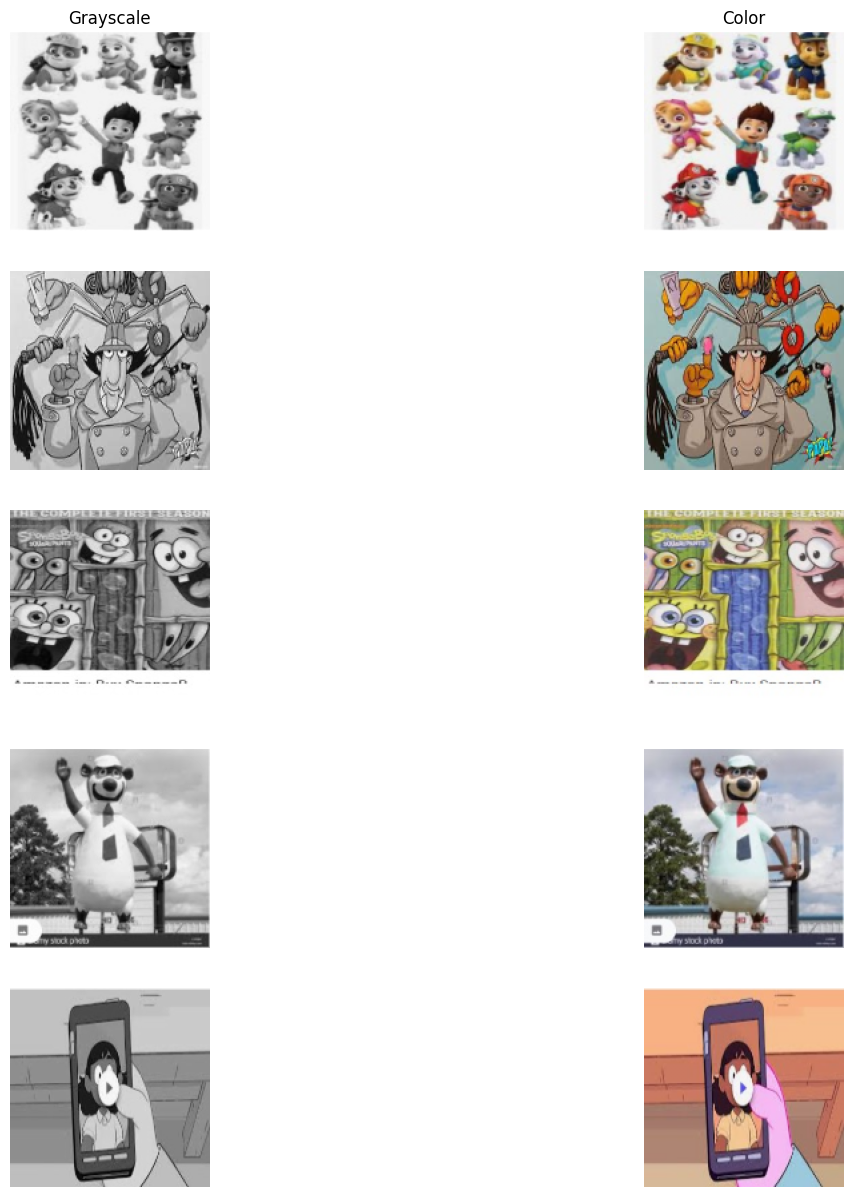

In [6]:

color, gray = next(iter(trainloader))
show_images(color, gray)

In [7]:

# Training Variables

EPOCHS = 500
LEARNING_RATE = 0.001
MOMENTUM = 0.9
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
# DEVICE = 'cpu'

cuda


In [8]:
# Create the autoencoder model
class ColorAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Input shape: Bx1x150x150
        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.down1 = nn.Conv2d(1, 64, 3, stride=2) # Bx64x74x74
        self.down2 = nn.Conv2d(64, 128, 3, stride=2, padding=1) # Bx128x37x37
        self.down3 = nn.Conv2d(128, 256, 3, stride=2, padding=1) # Bx256x19x29
        self.down4 = nn.Conv2d(256, 512, 3, stride=2, padding=1) # Bx512x10x10

        self.up1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=1)
        self.up3 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=1)
        self.up4 = nn.ConvTranspose2d(128, 3, 3, stride=2, output_padding=1)

        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Down sample
        d1 = self.relu(self.down1(x))
        d2 = self.relu(self.down2(d1))
        d3 = self.relu(self.down3(d2))
        d4 = self.relu(self.down4(d3))
        # Upsample
        u1 = self.relu(self.up1(d4))
        u2 = self.relu(self.up2(torch.cat((u1,d3), dim=1)))
        u3 = self.relu(self.up3(torch.cat((u2, d2), dim=1)))
        u4 = self.sigmoid(self.up4(torch.cat((u3,d1), dim=1)))

        return u4

In [9]:
# <!-- self.up2 = nn.ConvTranspose2d(512, 128, 3, stride=2, padding=0)
# self.up3 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=0)
# self.up4 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=0, output_padding=1)
# self.up4 = nn.ConvTranspose2d(256, 64, 3, stride=2, padding=1, output_padding=0) -->

In [10]:

# Initialize the model
model = ColorAutoEncoder().to(DEVICE)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
f"Total Number of trainable parameters of this model are: {total_params:,}"

'Total Number of trainable parameters of this model are: 3,470,659'

In [11]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
model = model.to(DEVICE)

In [ ]:
for epoch in range(EPOCHS):
    running_loss = 0.0
    for idx, (color_img, gray_img) in tqdm(enumerate(trainloader), total=len(trainloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        # Make model predictions
        predictions = model(gray_img)

        optimizer.zero_grad()
        # Calculate loss between coloured image and predicted image
        loss = criterion(color_img, predictions)

        # Calcuate gradients and back propagate
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch: {epoch + 1}, Loss: {running_loss:.6f}')

print('Training Finished!')

  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 1, Loss: 3.791000


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 2, Loss: 2.453612


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 3, Loss: 2.327422


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 4, Loss: 2.272735


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 5, Loss: 2.240464


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 6, Loss: 2.214217


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 7, Loss: 2.197084


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 8, Loss: 2.177827


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 9, Loss: 2.179614


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 10, Loss: 2.142948


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 11, Loss: 2.140455


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 12, Loss: 2.138486


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 13, Loss: 2.128768


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 14, Loss: 2.120826


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 15, Loss: 2.103840


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 16, Loss: 2.094102


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 17, Loss: 2.082721


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 18, Loss: 2.078889


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 19, Loss: 2.077569


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 20, Loss: 2.054383


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 21, Loss: 2.046296


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 22, Loss: 2.023131


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 23, Loss: 2.007539


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 24, Loss: 1.980349


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 25, Loss: 1.949076


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 26, Loss: 1.909324


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 27, Loss: 1.874761


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 28, Loss: 1.829899


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 29, Loss: 1.774031


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 30, Loss: 1.722179


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 31, Loss: 1.660386


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 32, Loss: 1.595899


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 33, Loss: 1.523150


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 34, Loss: 1.460130


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 35, Loss: 1.397126


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 36, Loss: 1.338398


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 37, Loss: 1.281412


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 38, Loss: 1.232323


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 39, Loss: 1.178622


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 40, Loss: 1.123244


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 41, Loss: 1.085641


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 42, Loss: 1.041520


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 43, Loss: 1.006270


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 44, Loss: 0.986638


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 45, Loss: 0.943298


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 46, Loss: 0.921266


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 47, Loss: 0.885549


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 48, Loss: 0.864970


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 49, Loss: 0.839678


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 50, Loss: 0.819513


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 51, Loss: 0.793773


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 52, Loss: 0.779452


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 53, Loss: 0.772040


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 54, Loss: 0.772409


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 55, Loss: 0.735499


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 56, Loss: 0.718515


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 57, Loss: 0.713416


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 58, Loss: 0.698997


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 59, Loss: 0.687755


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 60, Loss: 0.677374


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 61, Loss: 0.664582


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 62, Loss: 0.657352


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 63, Loss: 0.648601


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 64, Loss: 0.648917


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 65, Loss: 0.642919


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 66, Loss: 0.627033


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 67, Loss: 0.632886


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 68, Loss: 0.605936


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 69, Loss: 0.605454


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 70, Loss: 0.605149


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 71, Loss: 0.595144


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 72, Loss: 0.590604


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 73, Loss: 0.588160


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 74, Loss: 0.568078


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 75, Loss: 0.564086


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 76, Loss: 0.580647


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 77, Loss: 0.569578


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 78, Loss: 0.563359


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 79, Loss: 0.554999


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 80, Loss: 0.577855


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 81, Loss: 0.583921


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 82, Loss: 0.548822


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 83, Loss: 0.560879


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 84, Loss: 0.532468


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 85, Loss: 0.530766


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 86, Loss: 0.518798


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 87, Loss: 0.530459


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 88, Loss: 0.525409


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 89, Loss: 0.528759


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 90, Loss: 0.536307


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 91, Loss: 0.512655


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 92, Loss: 0.500189


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 93, Loss: 0.495885


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 94, Loss: 0.493640


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 95, Loss: 0.521447


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 96, Loss: 0.502897


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 97, Loss: 0.490302


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 98, Loss: 0.491989


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 99, Loss: 0.483103


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 100, Loss: 0.481815


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 101, Loss: 0.481751


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 102, Loss: 0.478248


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 103, Loss: 0.487050


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 104, Loss: 0.481525


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 105, Loss: 0.489190


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 106, Loss: 0.487726


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 107, Loss: 0.490174


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 108, Loss: 0.479552


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 109, Loss: 0.480860


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 110, Loss: 0.468675


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 111, Loss: 0.461181


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 112, Loss: 0.467856


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 113, Loss: 0.469950


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 114, Loss: 0.461030


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 115, Loss: 0.457008


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 116, Loss: 0.458355


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 117, Loss: 0.459118


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 118, Loss: 0.465386


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 119, Loss: 0.460629


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 120, Loss: 0.469551


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 121, Loss: 0.459812


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 122, Loss: 0.438437


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 123, Loss: 0.437524


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 124, Loss: 0.436827


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 125, Loss: 0.451075


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 126, Loss: 0.452506


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 127, Loss: 0.434881


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 128, Loss: 0.433478


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 129, Loss: 0.434255


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 130, Loss: 0.469282


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 131, Loss: 0.434573


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 132, Loss: 0.431727


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 133, Loss: 0.428632


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 134, Loss: 0.426511


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 135, Loss: 0.426220


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 136, Loss: 0.415436


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 137, Loss: 0.448812


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 138, Loss: 0.450918


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 139, Loss: 0.428099


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 140, Loss: 0.430545


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 141, Loss: 0.459551


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 142, Loss: 0.428653


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 143, Loss: 0.436464


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 144, Loss: 0.415053


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 145, Loss: 0.410316


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 146, Loss: 0.408047


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 147, Loss: 0.406703


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 148, Loss: 0.409065


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 149, Loss: 0.405818


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 150, Loss: 0.405027


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 151, Loss: 0.422191


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 152, Loss: 0.483516


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 153, Loss: 0.443165


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 154, Loss: 0.423105


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 155, Loss: 0.406208


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 156, Loss: 0.397160


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 157, Loss: 0.388988


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 158, Loss: 0.393932


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 159, Loss: 0.402444


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 160, Loss: 0.407998


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 161, Loss: 0.402190


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 162, Loss: 0.399968


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 163, Loss: 0.414563


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 164, Loss: 0.442338


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 165, Loss: 0.416199


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 166, Loss: 0.411223


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 167, Loss: 0.402117


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 168, Loss: 0.394121


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 169, Loss: 0.395808


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 170, Loss: 0.399505


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 171, Loss: 0.454982


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 172, Loss: 0.405341


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 173, Loss: 0.388901


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 174, Loss: 0.384246


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 175, Loss: 0.378803


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 176, Loss: 0.377870


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 177, Loss: 0.386349


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 178, Loss: 0.392501


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 179, Loss: 0.417467


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 180, Loss: 0.417108


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 181, Loss: 0.406353


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 182, Loss: 0.389217


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 183, Loss: 0.392798


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 184, Loss: 0.389590


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 185, Loss: 0.378021


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 186, Loss: 0.375573


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 187, Loss: 0.375906


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 188, Loss: 0.376676


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 189, Loss: 0.378904


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 190, Loss: 0.376824


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 191, Loss: 0.388794


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 192, Loss: 0.421386


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 193, Loss: 0.386787


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 194, Loss: 0.382458


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 195, Loss: 0.396135


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 196, Loss: 0.379344


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 197, Loss: 0.371996


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 198, Loss: 0.372188


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 199, Loss: 0.367408


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 200, Loss: 0.379022


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 201, Loss: 0.369868


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 202, Loss: 0.372899


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 203, Loss: 0.380242


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 204, Loss: 0.373309


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 205, Loss: 0.374829


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 206, Loss: 0.381413


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 207, Loss: 0.422036


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 208, Loss: 0.404246


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 209, Loss: 0.385699


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 210, Loss: 0.365700


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 211, Loss: 0.362506


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 212, Loss: 0.362674


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 213, Loss: 0.355257


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 214, Loss: 0.356081


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 215, Loss: 0.361047


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 216, Loss: 0.376022


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 217, Loss: 0.368985


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 218, Loss: 0.360605


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 219, Loss: 0.365258


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 220, Loss: 0.383053


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 221, Loss: 0.375735


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 222, Loss: 0.364467


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 223, Loss: 0.359490


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 224, Loss: 0.361448


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 225, Loss: 0.376653


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 226, Loss: 0.371171


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 227, Loss: 0.382641


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 228, Loss: 0.359706


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 229, Loss: 0.356881


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 230, Loss: 0.365407


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 231, Loss: 0.373797


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 232, Loss: 0.367207


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 233, Loss: 0.372819


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 234, Loss: 0.356698


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 235, Loss: 0.352904


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 236, Loss: 0.351480


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 237, Loss: 0.350796


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 238, Loss: 0.358061


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 239, Loss: 0.355607


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 240, Loss: 0.354519


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 241, Loss: 0.358490


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 242, Loss: 0.355629


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 243, Loss: 0.355555


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 244, Loss: 0.356513


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 245, Loss: 0.361901


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 246, Loss: 0.390541


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 247, Loss: 0.361488


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 248, Loss: 0.351453


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 249, Loss: 0.352126


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 250, Loss: 0.355229


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 251, Loss: 0.361480


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 252, Loss: 0.351360


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 253, Loss: 0.371233


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 254, Loss: 0.351222


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 255, Loss: 0.351793


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 256, Loss: 0.359113


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 257, Loss: 0.344476


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 258, Loss: 0.347166


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 259, Loss: 0.341149


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 260, Loss: 0.337649


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 261, Loss: 0.367071


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 262, Loss: 0.364328


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 263, Loss: 0.368142


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 264, Loss: 0.355916


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 265, Loss: 0.350682


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 266, Loss: 0.351297


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 267, Loss: 0.343726


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 268, Loss: 0.340478


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 269, Loss: 0.336057


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 270, Loss: 0.338169


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 271, Loss: 0.338405


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 272, Loss: 0.342242


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 273, Loss: 0.342640


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 274, Loss: 0.351658


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 275, Loss: 0.366567


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 276, Loss: 0.352897


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 277, Loss: 0.349581


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 278, Loss: 0.371915


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 279, Loss: 0.389675


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 280, Loss: 0.362375


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 281, Loss: 0.341968


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 282, Loss: 0.334273


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 283, Loss: 0.334271


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 284, Loss: 0.328521


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 285, Loss: 0.331899


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 286, Loss: 0.343897


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 287, Loss: 0.349116


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 288, Loss: 0.339667


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 289, Loss: 0.344004


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 290, Loss: 0.338024


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 291, Loss: 0.342155


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 292, Loss: 0.337447


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 293, Loss: 0.336557


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 294, Loss: 0.333468


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 295, Loss: 0.330916


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 296, Loss: 0.336173


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 297, Loss: 0.356969


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 298, Loss: 0.364740


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 299, Loss: 0.343931


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 300, Loss: 0.342984


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 301, Loss: 0.342503


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 302, Loss: 0.333853


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 303, Loss: 0.333394


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 304, Loss: 0.330127


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 305, Loss: 0.334001


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 306, Loss: 0.354008


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 307, Loss: 0.349487


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 308, Loss: 0.391030


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 309, Loss: 0.348113


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 310, Loss: 0.335958


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 311, Loss: 0.343105


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 312, Loss: 0.328414


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 313, Loss: 0.325030


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 314, Loss: 0.329026


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 315, Loss: 0.328917


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 316, Loss: 0.326369


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 317, Loss: 0.329037


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 318, Loss: 0.334024


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 319, Loss: 0.328298


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 320, Loss: 0.328671


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 321, Loss: 0.333213


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 322, Loss: 0.330481


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 323, Loss: 0.330146


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 324, Loss: 0.331746


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 325, Loss: 0.349534


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 326, Loss: 0.340900


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 327, Loss: 0.338608


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 328, Loss: 0.341549


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 329, Loss: 0.330235


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 330, Loss: 0.326013


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 331, Loss: 0.325544


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 332, Loss: 0.335989


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 333, Loss: 0.343806


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 334, Loss: 0.342787


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 335, Loss: 0.329653


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 336, Loss: 0.325483


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 337, Loss: 0.336541


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 338, Loss: 0.332953


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 339, Loss: 0.331784


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 340, Loss: 0.333913


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 341, Loss: 0.328701


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 342, Loss: 0.323524


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 343, Loss: 0.328550


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 344, Loss: 0.333005


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 345, Loss: 0.335274


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 346, Loss: 0.390238


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 347, Loss: 0.372750


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 348, Loss: 0.346827


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 349, Loss: 0.327321


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 350, Loss: 0.318608


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 351, Loss: 0.319724


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 352, Loss: 0.319475


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 353, Loss: 0.317279


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 354, Loss: 0.324890


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 355, Loss: 0.320838


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 356, Loss: 0.323855


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 357, Loss: 0.318498


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 358, Loss: 0.318444


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 359, Loss: 0.323964


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 360, Loss: 0.324216


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 361, Loss: 0.328812


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 362, Loss: 0.327705


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 363, Loss: 0.319867


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 364, Loss: 0.320290


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 365, Loss: 0.317922


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 366, Loss: 0.319677


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 367, Loss: 0.330124


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 368, Loss: 0.333430


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 369, Loss: 0.332315


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 370, Loss: 0.330613


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 371, Loss: 0.326486


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 372, Loss: 0.321807


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 373, Loss: 0.319731


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 374, Loss: 0.315873


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 375, Loss: 0.352497


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 376, Loss: 0.341184


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 377, Loss: 0.342638


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 378, Loss: 0.341116


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 379, Loss: 0.319070


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 380, Loss: 0.313320


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 381, Loss: 0.312398


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 382, Loss: 0.316978


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 383, Loss: 0.318886


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 384, Loss: 0.319503


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 385, Loss: 0.319833


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 386, Loss: 0.318138


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 387, Loss: 0.319528


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 388, Loss: 0.320818


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 389, Loss: 0.322265


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 390, Loss: 0.320798


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 391, Loss: 0.326410


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 392, Loss: 0.316131


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 393, Loss: 0.320739


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 394, Loss: 0.320024


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 395, Loss: 0.314779


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 396, Loss: 0.316273


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 397, Loss: 0.323894


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 398, Loss: 0.318675


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 399, Loss: 0.322088


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 400, Loss: 0.326153


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 401, Loss: 0.317237


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 402, Loss: 0.317169


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 403, Loss: 0.314360


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 404, Loss: 0.308580


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 405, Loss: 0.320983


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 406, Loss: 0.423829


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 407, Loss: 0.358637


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 408, Loss: 0.324755


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 409, Loss: 0.346431


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 410, Loss: 0.318458


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 411, Loss: 0.308800


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 412, Loss: 0.304025


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 413, Loss: 0.305926


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 414, Loss: 0.305758


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 415, Loss: 0.305639


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 416, Loss: 0.304637


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 417, Loss: 0.311193


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 418, Loss: 0.311047


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 419, Loss: 0.321013


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 420, Loss: 0.319354


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 421, Loss: 0.312434


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 422, Loss: 0.309651


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 423, Loss: 0.309716


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 424, Loss: 0.311978


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 425, Loss: 0.319434


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 426, Loss: 0.325563


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 427, Loss: 0.330398


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 428, Loss: 0.316636


  0%|          | 0/105 [00:00<?, ?it/s]

Epoch: 429, Loss: 0.306416


  0%|          | 0/105 [00:00<?, ?it/s]

In [27]:
total_loss = 0.0
with torch.no_grad():
    for idx, (color_img, gray_img) in tqdm(enumerate(testloader), total=len(testloader)):
        color_img = color_img.to(DEVICE)
        gray_img = gray_img.to(DEVICE)

        prediction = model(gray_img)

        
        loss = criterion(prediction, color_img)
        total_loss += loss.item()

f"Total Testing loss is: {total_loss/ len(testloader):.3f}"

  0%|          | 0/27 [00:00<?, ?it/s]

'Total Testing loss is: 0.030'

In [28]:
_, gray = next(iter(trainloader))
gray.shape

torch.Size([32, 1, 150, 150])

In [31]:
# img1_color=[]
# img1 = (('images/img.png'))
# img1 = resize(img1 ,(256,256))
# img1_color.append(img1)

In [38]:
from PIL import Image
import torchvision.transforms as transforms
import torch

# Load the image
image_path = '/kaggle/input/cartoondata/Training Data/gray/01018.jpeg'  # Replace with the path to your image
image = Image.open(image_path)

# Convert the image to grayscale
image_gray = image.convert('L')

# Preprocess the grayscale image
preprocess = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
])
input_tensor = preprocess(image_gray)

# Add a batch dimension
input_batch = input_tensor.unsqueeze(0)

# Move the input tensor to the device
input_batch = input_batch.to(DEVICE)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)


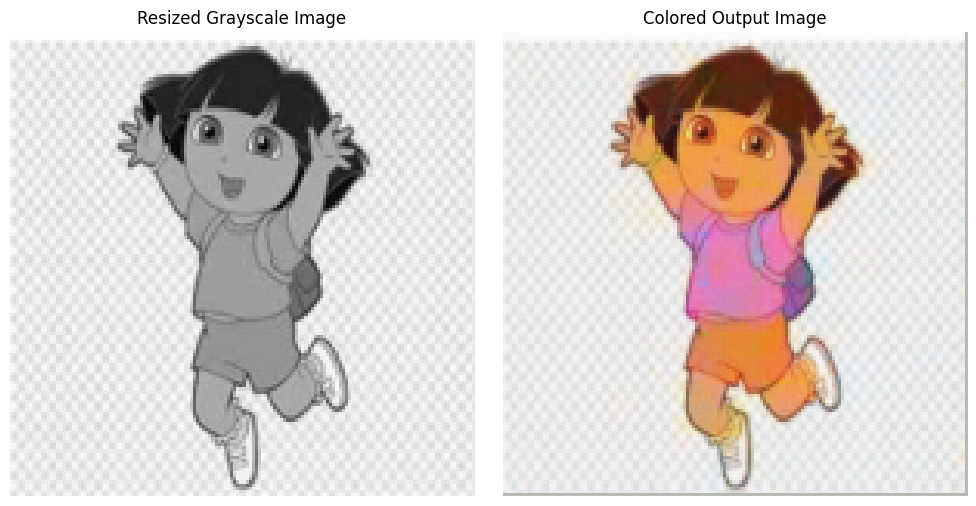

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Convert the output tensor to a numpy array
output_image = output.squeeze(0).cpu().numpy()

# Ensure the image is in the correct shape (height, width, channels)
output_image = np.transpose(output_image, (1, 2, 0))

# Load the original grayscale image and resize it to 150x150
image_gray = Image.open(image_path).convert('L')
image_gray_resized = image_gray.resize((150, 150))

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Display the original grayscale image
axs[0].imshow(image_gray_resized, cmap='gray')
axs[0].axis('off')
axs[0].set_title('Resized Grayscale Image')

# Display the colored output image
axs[1].imshow(output_image)
axs[1].axis('off')
axs[1].set_title('Colored Output Image')

# Show the plot
plt.tight_layout()
plt.show()
